<a target="_blank" href="https://colab.research.google.com/github/heechul/DeepPicar-v3/blob/devel/RunAll.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import math
# from skimage import data
from skimage import io
from skimage.exposure import match_histograms

In [2]:
print(tf.__version__)

use_int8 = True  # use int8 input tensor
print("use_int8: ", use_int8)

2.14.0
use_int8:  True


In [3]:
# input image resolution to the DNN model (smaller than the original dataset image resolution: 320x240x3)
img_width = 160
img_height = 66
img_channels = 3

model_name = "model_opt"
model_file = "models/{}-{}x{}x{}".format(model_name[6:], img_width, img_height, img_channels)

In [4]:
import requests 
import os
import zipfile

dataset_dir = "dataset"
dataset_zipfile = 'labtrack-leftonly-RTCSA22.zip' # 'Dataset-kucsl-Aug2022-zero.zip' # 'labtrack-leftonly-RTCSA22.zip' # 'Dataset.zip'
RunningInCOLAB = 'google.colab' in str(get_ipython())
force_unzip = False

if RunningInCOLAB: 
    print("in colab")
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
        dataset_zipfile = fn  # expecting a zip file to be uploaded. 
else:
    print ("not in colab")
    # RPI_IP=None # replace this with the IP address of your raspberry pi 
    # if RPI_IP is not None:
    #     URL="http://"+RPI_IP+":8000/"+dataset_zipfile
    #     filename=URL.split('/')[-1]
    #     r = requests.get(URL)
    #     open(filename, 'wb').write(r.content)

# if not os.path.isfile(dataset_zipfile):
#     default_dataset_URL = "https://raw.githubusercontent.com/heechul/DeepPicar-v3/devel/Dataset-kucsl-Apr2022.zip"    
#     print ("No existing dataset. download from ", default_dataset_URL)
#     r = requests.get(default_dataset_URL)
#     open(dataset_zipfile, 'wb').write(r.content)

if not os.path.isdir(dataset_dir) or force_unzip==True:
    print ('unzip %s into %s folder' % (dataset_zipfile, dataset_dir))
    zip_ref = zipfile.ZipFile(dataset_zipfile)
    zip_ref.extractall(dataset_dir)

not in colab


In [5]:
# Train/test data lists
imgs = []
vals = []

def rad2deg(rad):
    return 180.0 * rad / math.pi
def deg2rad(deg):
    return math.pi * deg / 180.0

# scaled crop. return img_height x img_width image
def get_image(img):
    orig_h, orig_w, _ = img.shape
    scaled_h = int(orig_h * img_width / orig_w)
    scaled_w = img_width
    # print(scaled_w, scaled_h)
    scaled_img = cv2.resize(img, (scaled_w, scaled_h))
    # print(scaled_img.shape)
    # crop bottom center pixels of the model input size
    startx = int((scaled_w - img_width) * 0.5);
    starty = int((scaled_h - img_height) * 1.0);
    return scaled_img[starty:starty+img_height, startx:startx+img_width,:]

def preprocess(img):
    img = get_image(img)
    # Convert to grayscale and readd channel dimension
    if img_channels == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.reshape(img, (img_height, img_width, img_channels))
    if use_int8 == True:
        img = (img - 128).astype(np.int8)
    else:
        img = img.astype(np.float32) / 255.0
    return img

import glob
for vid_file_path in glob.iglob(f'{dataset_dir}/*.avi'):
    csv_file_path = vid_file_path.replace('video', 'key').replace('avi', 'csv')
    print(vid_file_path, csv_file_path)
    vid = cv2.VideoCapture(vid_file_path)
    df = read_csv(csv_file_path)

    for val in df["wheel"].values:
        ret,img = vid.read()
        img = preprocess(img)
        imgs.append(img)
        vals.append(val)
    print(len(imgs), len(vals))

# Convert lists to numpy arrays and ensure they are of equal length    
imgs = np.asarray(imgs)  # input images
vals = np.asarray(vals)  # steering angles
assert len(imgs) == len(vals)
print("Loaded {} smaples".format(len(imgs)))

dataset/out-video-t85-4.avi dataset/out-key-t85-4.csv
1000 1000
dataset/out-video-t85-2.avi dataset/out-key-t85-2.csv
2000 2000
dataset/out-video-t85-3.avi dataset/out-key-t85-3.csv
3000 3000
dataset/out-video-t85-1.avi dataset/out-key-t85-1.csv
4000 4000
dataset/out-video-t80-2.avi dataset/out-key-t80-2.csv
5000 5000
dataset/out-video-t80-1.avi dataset/out-key-t80-1.csv
6000 6000
dataset/out-video-t90-1.avi dataset/out-key-t90-1.csv
7000 7000
dataset/out-video-t90-2.avi dataset/out-key-t90-2.csv
8000 8000
Loaded 8000 smaples


In [6]:
# Split the dataset for train and test 
print("Train/Test")
x_train, x_test, y_train, y_test = train_test_split(imgs, vals, test_size=0.35)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

print("class_weights", class_weights)
class_weights = {i:class_weights[i] for i in range(len(class_weights))}
print("class_weights", class_weights)


Train/Test
class_weights [1.38777689 0.60164295 1.61993769]
class_weights {0: 1.3877768881772083, 1: 0.6016429480504455, 2: 1.6199376947040498}


In [7]:
len(x_train)

5200

In [8]:
from keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# original model
model = tf.keras.Sequential()
model.add(layers.Conv2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(img_height,img_width,img_channels)))
model.add(layers.Conv2D(36, (5,5), strides=(2,2), activation='relu'))
model.add(layers.Conv2D(48, (5,5), strides=(2,2), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, name="output", activation='tanh'))

model.summary()

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 78, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 37, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 17, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 15, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 13, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 832)               0         
                                                                 
 dense (Dense)               (None, 100)               8

In [9]:
print("Quantize Model")
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

print ("Model compile")
q_aware_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(3e-4),
		                loss=tf.keras.losses.MeanSquaredError())
q_aware_model.summary()

Quantize Model
Model compile
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 66, 160, 3)        3         
 yer)                                                            
                                                                 
 quant_conv2d (QuantizeWrap  (None, 31, 78, 24)        1875      
 perV2)                                                          
                                                                 
 quant_conv2d_1 (QuantizeWr  (None, 14, 37, 36)        21711     
 apperV2)                                                        
                                                                 
 quant_conv2d_2 (QuantizeWr  (None, 5, 17, 48)         43347     
 apperV2)                                                        
                                                                 
 quant_conv2d_3 (QuantizeWr

Model fit
Epoch 1/25
21/21 [==============================] - 7s 291ms/step - loss: 0.1194 - val_loss: 0.0993
Epoch 2/25
21/21 [==============================] - 6s 277ms/step - loss: 0.0874 - val_loss: 0.0824
Epoch 3/25
21/21 [==============================] - 5s 254ms/step - loss: 0.0700 - val_loss: 0.0709
Epoch 4/25
21/21 [==============================] - 6s 279ms/step - loss: 0.0593 - val_loss: 0.0623
Epoch 5/25
21/21 [==============================] - 5s 261ms/step - loss: 0.0490 - val_loss: 0.0593
Epoch 6/25
21/21 [==============================] - 6s 268ms/step - loss: 0.0424 - val_loss: 0.0572
Epoch 7/25
21/21 [==============================] - 6s 265ms/step - loss: 0.0384 - val_loss: 0.0526
Epoch 8/25
21/21 [==============================] - 5s 252ms/step - loss: 0.0329 - val_loss: 0.0504
Epoch 9/25
21/21 [==============================] - 5s 251ms/step - loss: 0.0276 - val_loss: 0.0501
Epoch 10/25
21/21 [==============================] - 6s 287ms/step - loss: 0.0254 - val_lo

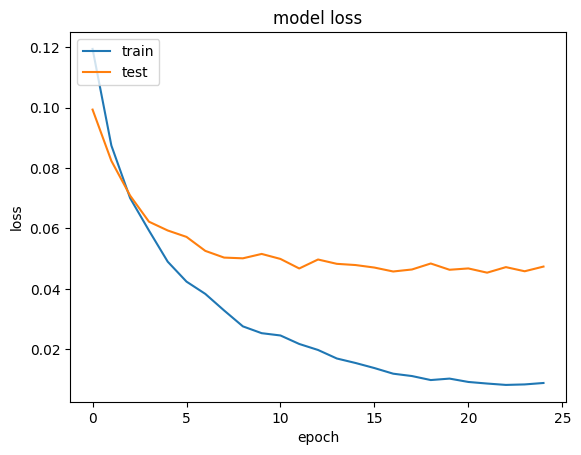

In [10]:
print ("Model fit")
# q_aware_model.reset_states()
history = q_aware_model.fit(x_train, y_train, batch_size=256,
                    epochs=25, validation_data=(x_test, y_test))

# Plot training and validation losses 
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
angle_thresh=10
# Helper functions for evaluating model accuracy

def get_action(angle_rad):
  degree = rad2deg(angle_rad)
  if degree < angle_thresh and degree > -angle_thresh:
    return "center"
  elif degree >= angle_thresh:
    return "right" 
  elif degree <-angle_thresh:
    return "left"

pred_angle = q_aware_model.predict(x_test)
pred = np.array(list(map(get_action, pred_angle)))
ground = np.array(list(map(get_action, y_test)))
print('Accuracy is %.3f' % np.mean(pred == ground))

88/88 [==============================] - 1s 12ms/step
Accuracy is 0.781


visualization

In [12]:
def plot_image(i, prediction_array, groundtrue_array, img_array):
  angle, predicted_label, groundtrue_label, img = int(rad2deg(pred_angle[i])), prediction_array[i], groundtrue_array[i], img_array[i]
  plt.grid(True)
  plt.xticks([])
  plt.yticks([])
  if use_int8 == True:
    img = np.round((img + 128.0) / 255.0, 2)
  else:
    img = np.squeeze(img)
  plt.imshow(img, cmap=plt.cm.binary)
  if predicted_label == groundtrue_label:
    color = 'green'
  else:
    color = 'red'  
  plt.xlabel("Predict:{} ({}) Actual:{}".format(predicted_label,angle,groundtrue_label), color=color)

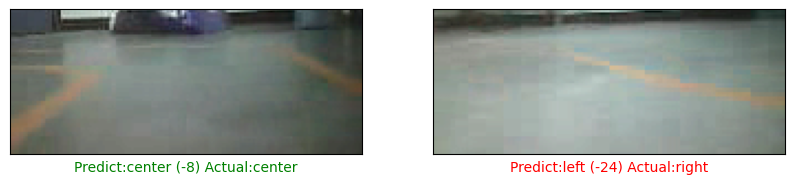

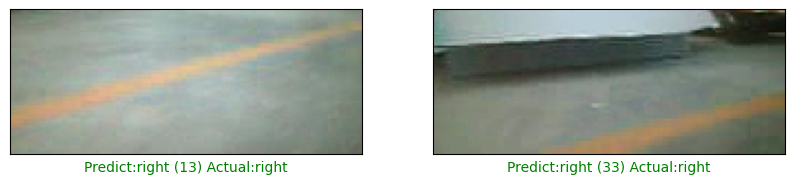

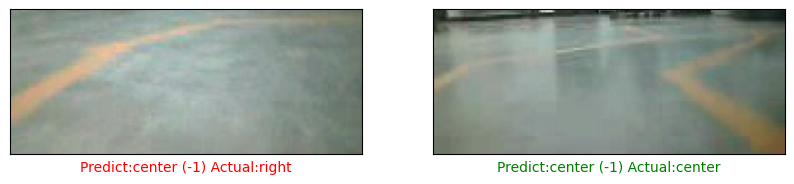

In [13]:
#@title Visualize the outputs { run: "auto" }
index = 100 #@param {type:"slider", min:0, max:244, step:6}
for i in range(3):
  plt.figure(figsize=(10,3))
  plt.subplot(1,2,1)
  plot_image(index + 2*i, pred, ground, x_test)
  plt.subplot(1,2,2)
  plot_image(index + 2*i+1, pred, ground, x_test)
  plt.show()

In [14]:
# Save both the Keras and TFLite models      
print("Model Save")                  
q_aware_model.save(model_file+".h5")

print("TFLite Model")
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

print("Using int8 quantization")

quantized_tflite_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

with open(model_file+".tflite", 'wb') as f:
    f.write(quantized_tflite_model)

print (model_file+".tflite is saved. copy this file to the robot")

if RunningInCOLAB: 
    from google.colab import files
    files.download(model_file+".tflite")

Model Save
TFLite Model
Using int8 quantization


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp4uegnbbi/assets


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp4uegnbbi/assets
/opt/homebrew/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-10-11 15:06:24.038304: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.


input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>
models/opt-160x66x3.tflite is saved. copy this file to the robot


2023-10-11 15:06:24.038583: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-11 15:06:24.039596: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp4uegnbbi
2023-10-11 15:06:24.042800: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-11 15:06:24.042806: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp4uegnbbi
2023-10-11 15:06:24.050618: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-10-11 15:06:24.054678: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-10-11 15:06:24.172527: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp4uegnbbi

generate cc file from tflite model

In [15]:
!xxd -i {model_file}.tflite > {model_file}.cc
print ("src/"+model_file[7:]+".cc is saved")
!cat {model_file}.cc | sed "s/unsigned/const unsigned/g" > src/{model_file[7:]}.cc

src/opt-160x66x3.cc is saved
